In [1]:
# ---------------------------------------------------------------

# ----------------- results specific framework

# ---------------------------------------------------------------


# ¡¡¡ --- !!! # ---> modules and data cases

# --- system modules

import sys
import datetime
import os


base_dir = os.path.abspath(os.getcwd() + "/..")

# --- data handling modules

import numpy as np
import pandas as pd
import scipy.io as sp_io
import scipy as sp

# --- visualization modules

import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import rcParams
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# --- my modules

methods_dir = base_dir + '/methods/'  
sys.path.insert(0, methods_dir)
from class_sample_selection import sample_selection
import simpls_module



# ¡¡¡ --- !!! # ---> base working directory and available data cases

# # ************************************ init --- user 
caseID_key = "d02_manure"
y_id = 1 # DM
# # ************************************ end --- user 



# # ¡¡¡ --- !!! # ---> data

mat_filename = base_dir + "/data/" + caseID_key +".mat"
data_mat = sp_io.loadmat(mat_filename, struct_as_record = False)



x_all = data_mat["xcal"].copy()
ycal = data_mat["ycal"].copy()[:,[y_id]]
# xtest = data_mat["xtest"].copy()
# ytest = data_mat["ytest"].copy()[:,[y_id]]
chemical_comp_name = data_mat["y_labels"][y_id]


# test_groups = np.ones(xtest.shape[0]).astype(int)

print(x_all.shape)

print("--- data ready ---")







(420, 141)
--- data ready ---


In [2]:
# --- svd full sample


X_c = x_all - x_all.mean(axis=0)
X_c_t = np.ascontiguousarray(X_c.transpose())
cov_X = X_c_t.dot(X_c)/X_c.shape[0]

svd_cov_X = np.linalg.svd(cov_X)

In [3]:
# --- get all results

df_design_pls = pd.read_pickle(base_dir + "/scripts_output/" + caseID_key + "_" + chemical_comp_name + "_numba_02_pls_performance.pkl")
method_name_match = [("random","RAND"),("ks","KS"),("duplex","DUP"),("puchwein","PUCH"),("clustering","CL"),("optfederov","D-OPT")]

method_name_match_df = pd.DataFrame(method_name_match)
method_name_match_df.columns = ["method_name","method_name_display"]
method_name_match_df

df_design_pls = df_design_pls.merge(method_name_match_df, how="left",left_on = "method_name", right_on = "method_name")
df_design_pls.shape
df_design_pls.columns

Index(['npc', 'method_name', 'sample_size', 'selected_samples', 'rmsecv',
       'rmseval', 'rmsep', 'r2cv', 'r2val', 'r2p', 'method_name_display'],
      dtype='object')

In [4]:
# --- svd subsets


# *******************
n_sel_range = np.arange(30, 400, 10)
chosen_rank_range = np.arange(15,30,5)
methods = np.array(['KS', 'DUP', 'PUCH', 'CL', 'D-OPT', 'RAND'])
# *******************

eigen_vals_ratio = np.zeros((n_sel_range.shape[0], chosen_rank_range[-1], methods.shape[0]))
eigen_vect_comparison = np.zeros((n_sel_range.shape[0], chosen_rank_range.shape[0],methods.shape[0]))


ii = 0
for n_sel in n_sel_range:
    jj = 0    
    for method in methods:
        kk=0
        for chosen_rank in chosen_rank_range:
            
            current_samples_filter = df_design_pls[(df_design_pls["method_name_display"]==method) & (df_design_pls["sample_size"]==n_sel) & (df_design_pls["npc"]==chosen_rank)]["selected_samples"] 
            current_samples = np.array(current_samples_filter)[0]
            x_selected = x_all[current_samples==1,:]
            Xs_c = x_selected - x_selected.mean(axis=0)
            Xs_c_t = np.ascontiguousarray(Xs_c.transpose())
            cov_Xs = Xs_c_t.dot(Xs_c)/Xs_c.shape[0]
            svd_selected = np.linalg.svd(cov_Xs)

            
            
            Vt_Vs = svd_selected[0][:,0:chosen_rank].T.dot(svd_cov_X[0][:,0:chosen_rank])
            eigen_vect_comparison[ii,kk,jj]=np.abs(np.linalg.det(Vt_Vs))
            
            if chosen_rank == chosen_rank_range[-1]:
                eigen_vals_ratio[ii,:,jj] = svd_selected[1][0:chosen_rank]/svd_cov_X[1][0:chosen_rank]
            
            kk+=1
                
        
        jj+=1
        
    ii+=1
print("done")

done


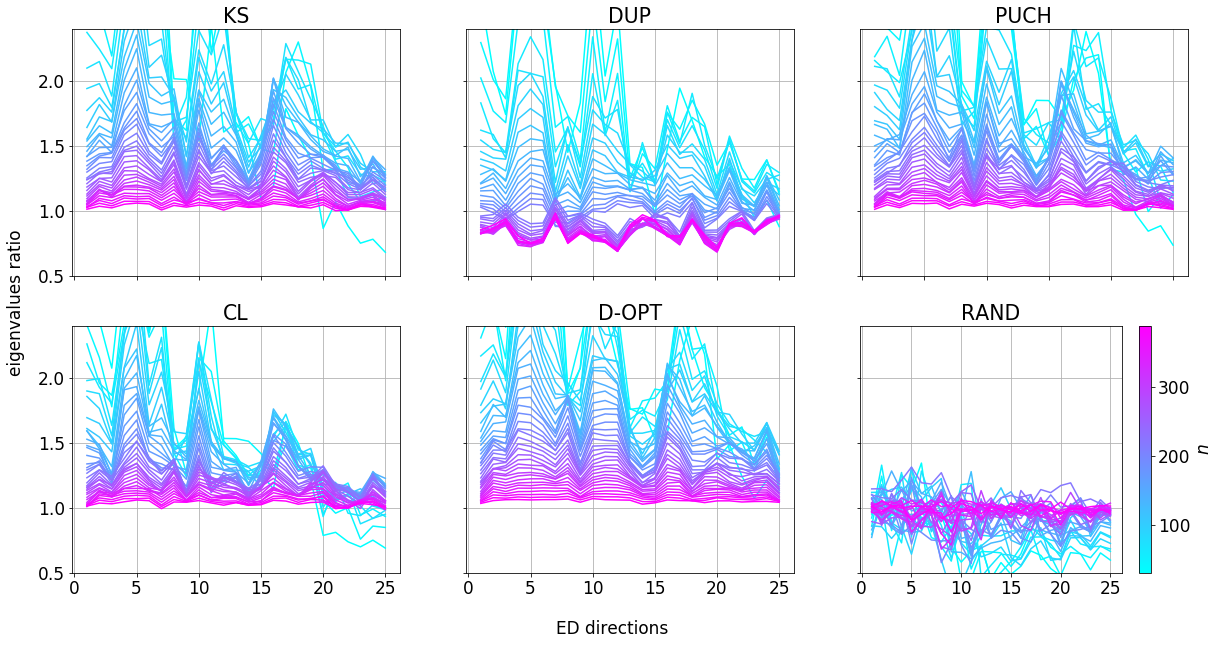

In [5]:
# --- plot eigenvals ratio color mapping

import matplotlib as mtply

color_var = np.array(n_sel_range)
min_color_var = np.amin(color_var)
max_color_var = np.amax(color_var)

c_m = mtply.cm.cool
norm = mtply.colors.Normalize(vmin = min_color_var, vmax = max_color_var)
s_m = mtply.cm.ScalarMappable(cmap = c_m, norm = norm)

methods_list = ['KS', 'DUP', 'PUCH', 'CL', 'D-OPT', 'RAND']

plt.rcParams.update({'font.size': 17})
fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (20,10), sharex=True, sharey=True)


jj = 0
for method in methods_list: 
    
    jj2 = jj
    
    if jj<3:
        k1=0
    else:
        k1=1
    
    if k1==1:
        jj2=jj-3

    for ii in range(eigen_vals_ratio.shape[0]):
        color_tuple = s_m.to_rgba(n_sel_range[ii])
        ax[k1,jj2].plot(np.arange(1,chosen_rank_range[-1]+1),eigen_vals_ratio[ii,:,jj], c = color_tuple)
    ax[k1,jj2].grid()
    ax[k1,jj2].set_title(method)
    ax[k1,jj2].set_ylim([0.5,2.4])
     
    jj+=1
    
fig.text(0.5, 0.04, 'ED directions', ha='center')
fig.text(0.08, 0.5, 'eigenvalues ratio', va='center', rotation='vertical')

cm = plt.colorbar(s_m)
cm.set_label("$n$")
plt.savefig(base_dir + "/manuscript/figures/"+caseID_key+"_specific_framework_eigenvalsratio.png",bbox_inches="tight")
plt.show()


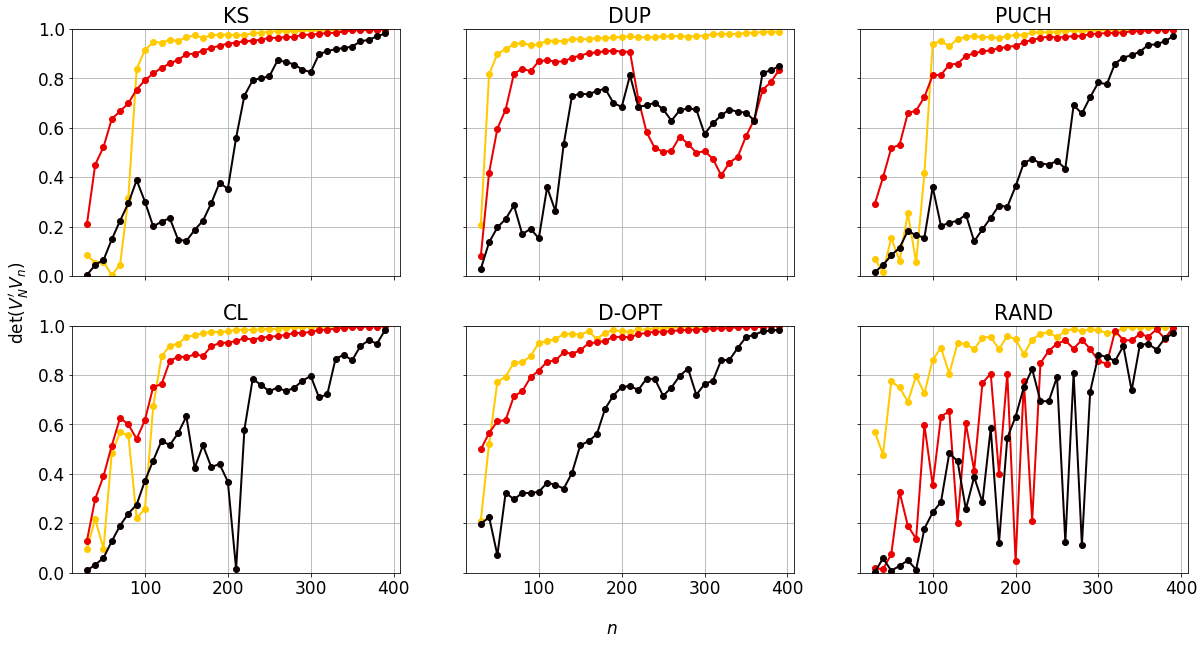

In [6]:
# --- plot eigenvect det



color_var = np.array(np.sort(np.unique(df_design_pls["npc"]))[:-1])
min_color_var = 10#np.amin(color_var)
max_color_var = 25#np.amax(color_var)

c_m = mtply.cm.hot_r
norm = mtply.colors.Normalize(vmin = min_color_var, vmax = max_color_var)
s_m = mtply.cm.ScalarMappable(cmap = c_m, norm = norm)


methods_list = ['KS', 'DUP', 'PUCH', 'CL', 'D-OPT', 'RAND']

plt.rcParams.update({'font.size': 17})
fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (20,10), sharex=True, sharey=True)


jj = 0
for method in methods_list: 
    
    jj2 = jj
    
    if jj<3:
        k1=0
    else:
        k1=1
    
    if k1==1:
        jj2=jj-3

    for ii in range(eigen_vect_comparison.shape[1]):
        color_tuple = s_m.to_rgba(chosen_rank_range[ii])
        ax[k1,jj2].plot(n_sel_range,eigen_vect_comparison[:,ii,jj],'o-', c = color_tuple,linewidth=2)
    ax[k1,jj2].grid()
    ax[k1,jj2].set_title(method)
    ax[k1,jj2].set_ylim([0,1])
     
    jj+=1

    
fig.text(0.5, 0.04, '$n$', ha='center')
fig.text(0.08, 0.5, "det($V_N'V_n$)", va='center', rotation='vertical')

    
#cm = fig.colorbar(s_m, boundaries = [chosen_rank_range[0]-5]+ list(chosen_rank_range) + [chosen_rank_range[-1]+5], extend="both")
#cm.set_label("$a$")
plt.savefig(base_dir + "/manuscript/figures/"+caseID_key+"_specific_framework_detereigevect.png",bbox_inches="tight")
plt.show()





In [7]:
# --- correlation table

corr_dict = {"pc":[], "corr":[]}
chosen_rank_corr = np.arange(0,10)


for rr in chosen_rank_corr:
    T_scores = x_all.dot(svd_cov_X[0][:,rr])
    corr = np.round(np.corrcoef(T_scores, ycal[:,0])[0,1],4)
    corr_dict["pc"].append(rr+1)
    corr_dict["corr"].append(corr)
    
corr_df = pd.DataFrame.from_dict(corr_dict)
print(corr_df.to_latex(index=False))  
print(corr_df)

\begin{tabular}{rr}
\toprule
 pc &    corr \\
\midrule
  1 & -0.3132 \\
  2 & -0.6231 \\
  3 & -0.1587 \\
  4 &  0.2220 \\
  5 &  0.4036 \\
  6 &  0.0299 \\
  7 & -0.3102 \\
  8 &  0.0521 \\
  9 &  0.1543 \\
 10 &  0.0259 \\
\bottomrule
\end{tabular}

   pc    corr
0   1 -0.3132
1   2 -0.6231
2   3 -0.1587
3   4  0.2220
4   5  0.4036
5   6  0.0299
6   7 -0.3102
7   8  0.0521
8   9  0.1543
9  10  0.0259
